In [162]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [163]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [164]:
using_colab = False

In [165]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from utils.thresholdingW import segment_otsu

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    mask=np.zeros(sorted_anns[0]['segmentation'].shape)
    mask_no=10
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        mask=mask+m*mask_no
        mask_no+=1
    ax.imshow(img)
    return mask

## Image preprocessing

In [168]:
from utils.thresholdingW import segment_otsu
img_path='/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict28/crops/wheat/vaib2.jpg'
edgeimg = cv2.imread("",cv2.IMREAD_GRAYSCALE)
image =  cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict28/crops/wheat/vaib2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

edgeimg=cv2.equalizeHist(edgeimg)
edgeimg = cv2.dilate(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=3)-cv2.erode(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[2,2]) ,iterations=2) 
edgeimg=cv2.equalizeHist(edgeimg)

edgeimg=cv2.merge([edgeimg]*3)/255
image=np.uint8(cv2.multiply(edgeimg,image/255)*255)


image = cv2.pyrUp(image)

# image = segment_otsu(image)


[ WARN:0@262291.068] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/morph.dispatch.cpp:1022: error: (-215:Assertion failed) !src.empty() in function 'dilate'


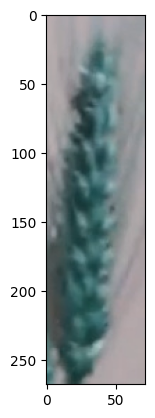

In [ ]:
plt.imshow(cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict28/crops/wheat/vaib2.jpg"))

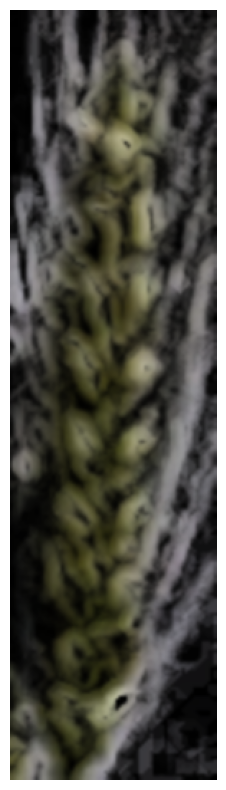

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation for initial segmentation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [301]:

image=cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/20240417_144500.jpg")
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [303]:
import numpy as np
import cv2 as cv

downImage = cv.pyrDown(image)
np.shape(downImage)

(2016, 1512, 3)

In [304]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [305]:
print(len(masks))
print(masks[0].keys())

151
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

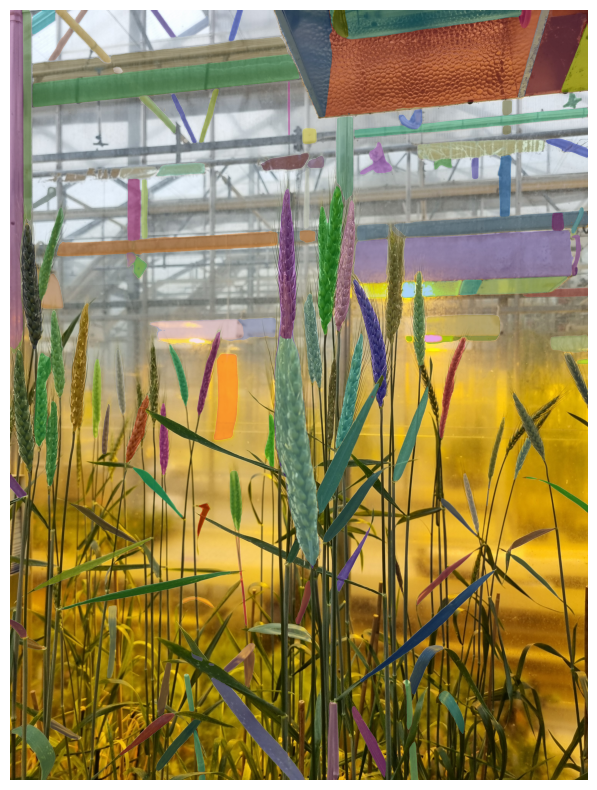

In [306]:
plt.figure(figsize=(10,10))
plt.imshow(image)
mask=show_anns(masks)
plt.axis('off')
plt.show() 

In [307]:
np.unique(mask)

# sam(image, bboxes=[939, 804, 141, 193])


array([  0.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,
        87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 16

In [311]:
mask[2000,50]

42.0

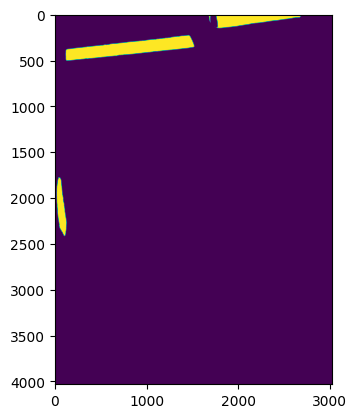

In [312]:
plt.imshow(mask==42)

In [ ]:
np.min(mask)

0.0

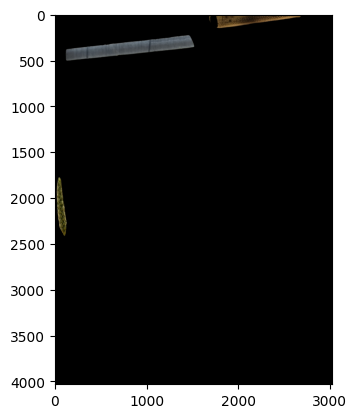

In [313]:
# batu = image.copy()
# batu[mask==0,:]=0
# batu[mask!=42,:]=0
# plt.imshow(batu)


True

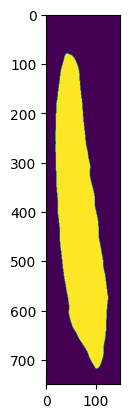

In [345]:
batu=(mask==42)*255
plt.imshow(batu[1700:2450,0:150])
cv2.imwrite('wh_sam_density.jpg',batu[1700:2450,0:150])

True

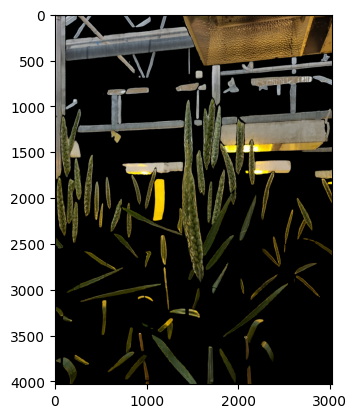

In [173]:
batu = image.copy()
batu[mask==0,:]=0
plt.imshow(batu)

cv2.imwrite('22april.jpg',batu)

In [174]:
mask[1500,1300]

0.0

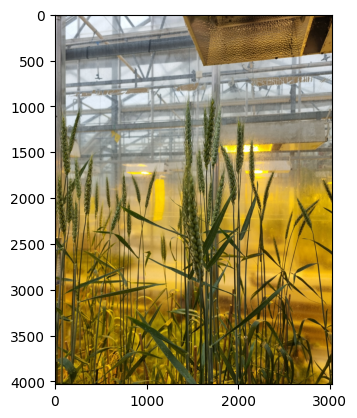

In [ ]:
plt.imshow(image)

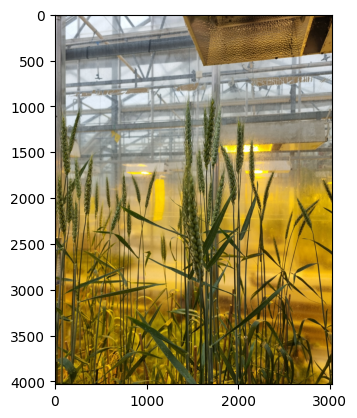

In [ ]:
batu = image.copy()
plt.imshow(batu)

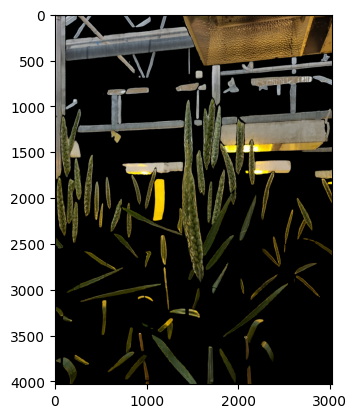

In [ ]:
batu[mask==0,:]=0
plt.imshow(batu)

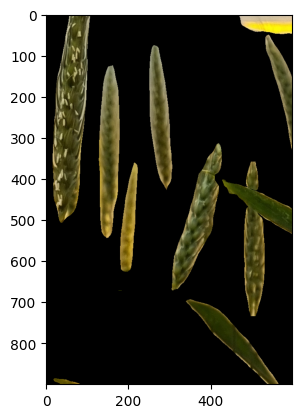

In [175]:
plt.imshow(batu[1700:2600, 300:900])



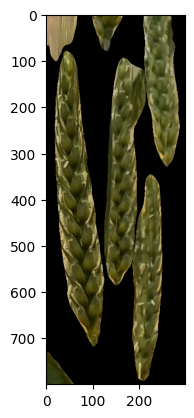

In [ ]:

plt.imshow(batu[1700:2500, 0:300])

In [ ]:

downImage = cv2.pyrDown(batu[1700:2500, 0:300])
np.shape(downImage)

(400, 150, 3)

300x800 original

75x350 # one wheat head resolution

In [176]:

grain_masks = mask_generator.generate(batu[1700:2500, 0:300])

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)





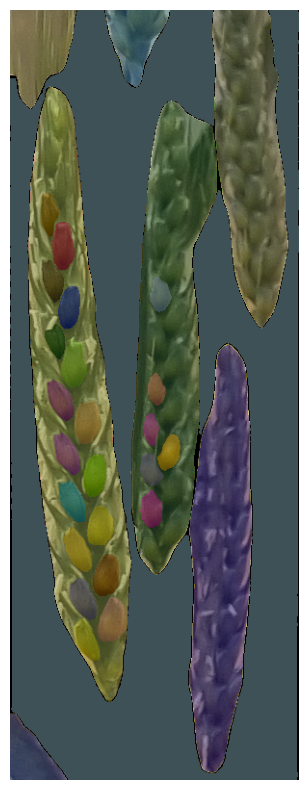

In [ ]:
# ORIGINAL RESOLUTION
plt.figure(figsize=(10,10))
plt.imshow(batu[1700:2500, 0:300])
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 

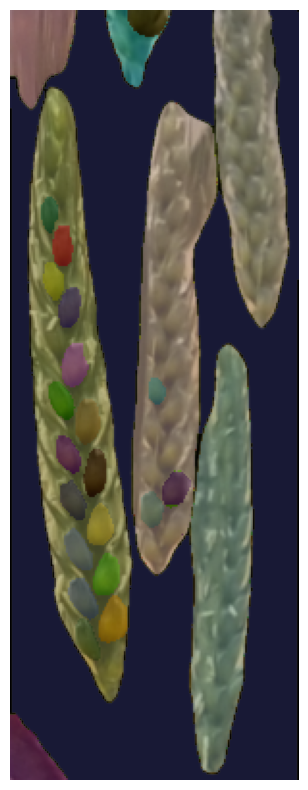

In [47]:
# DOWN SAMPLED BY HALF
downImage = cv2.pyrDown(batu[1700:2500, 0:300])
np.shape(downImage)
grain_masks = mask_generator.generate(downImage)
plt.figure(figsize=(10,10))
plt.imshow(downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 

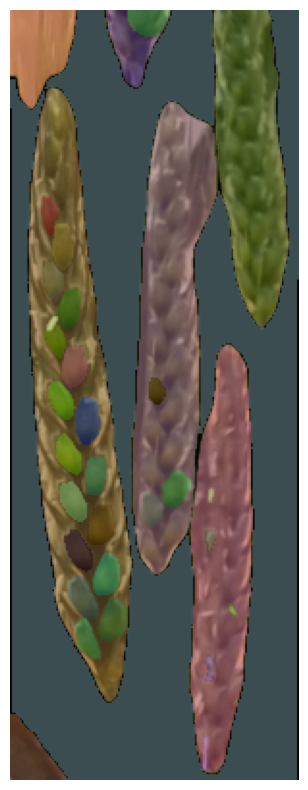

In [55]:
# DOWN SAMPLED BY HALF
downImage = cv2.pyrDown(batu[1700:2500, 0:300])
np.shape(downImage)
grain_masks = mask_generator_2.generate(downImage)
plt.figure(figsize=(10,10))
plt.imshow(downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 

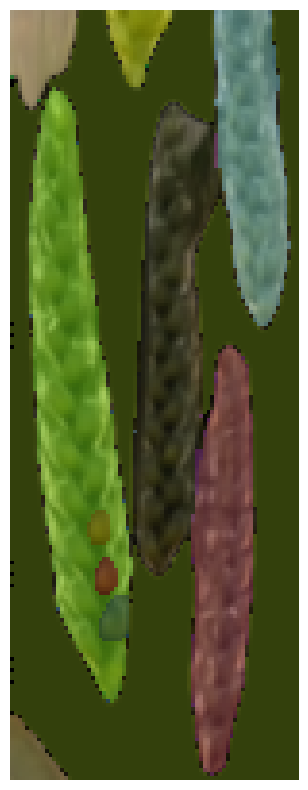

In [48]:
# DOUBLE DOWN IMAGE
double_downImage = cv2.pyrDown(downImage)
np.shape(double_downImage)

grain_masks = mask_generator.generate(double_downImage)

plt.figure(figsize=(10,10))
plt.imshow(double_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



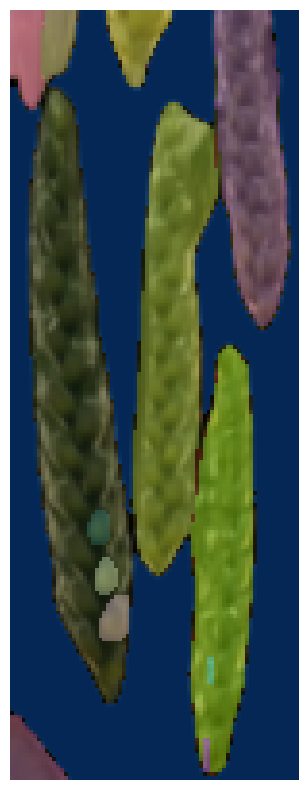

In [56]:
# DOUBLE DOWN IMAGE
double_downImage = cv2.pyrDown(downImage)
np.shape(double_downImage)

grain_masks = mask_generator_2.generate(double_downImage)

plt.figure(figsize=(10,10))
plt.imshow(double_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



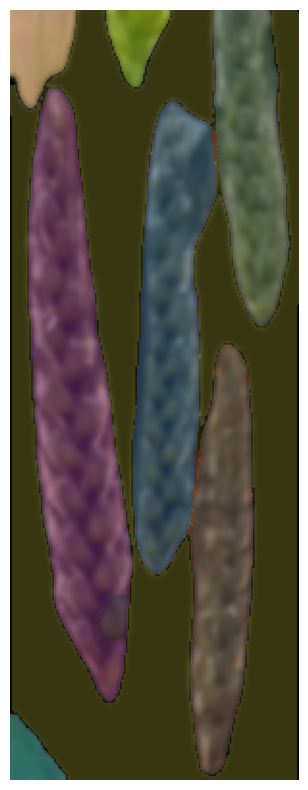

In [49]:
# DOUBLE DOWN IMAGE UP
updouble_downImage = cv2.pyrUp(double_downImage)
np.shape(updouble_downImage)

grain_masks = mask_generator.generate(updouble_downImage)

plt.figure(figsize=(10,10))
plt.imshow(updouble_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



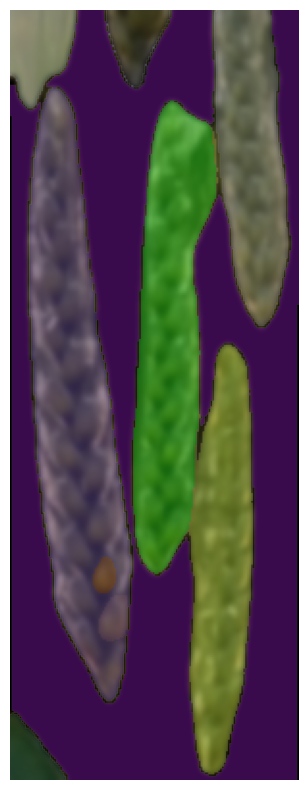

In [57]:
# DOUBLE DOWN IMAGE UP
updouble_downImage = cv2.pyrUp(double_downImage)
np.shape(updouble_downImage)

grain_masks = mask_generator_2.generate(updouble_downImage)

plt.figure(figsize=(10,10))
plt.imshow(updouble_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



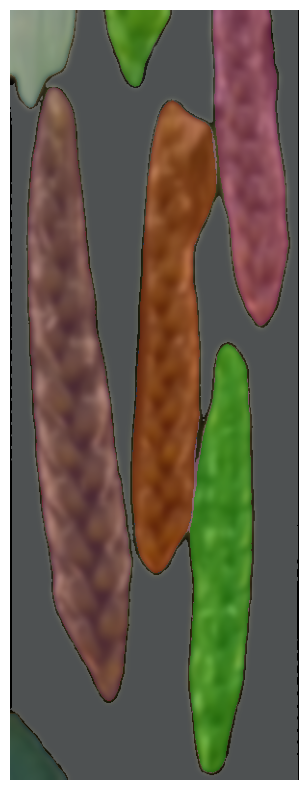

In [53]:
# DOUBLE DOWN IMAGE UP UP
up2double_downImage = cv2.pyrUp(updouble_downImage)
np.shape(up2double_downImage)

grain_masks = mask_generator.generate(up2double_downImage)

plt.figure(figsize=(10,10))
plt.imshow(up2double_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



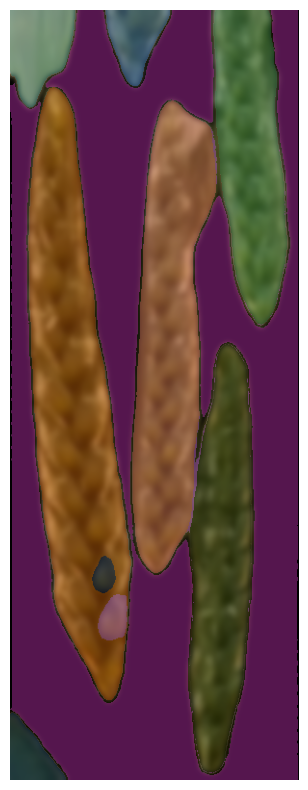

In [58]:
# DOUBLE DOWN IMAGE UP UP
up2double_downImage = cv2.pyrUp(updouble_downImage)
np.shape(up2double_downImage)

grain_masks = mask_generator_2.generate(up2double_downImage)

plt.figure(figsize=(10,10))
plt.imshow(up2double_downImage)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 



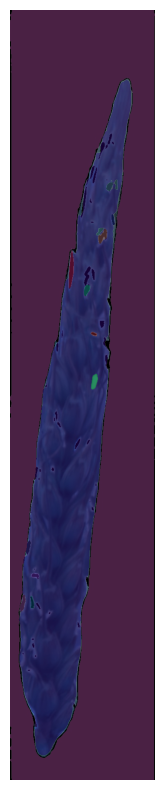

In [107]:
frame = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/batu_wh_HR.jpg")
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

grain_masks = mask_generator.generate(frame)

plt.figure(figsize=(10,10))
plt.imshow(frame)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 


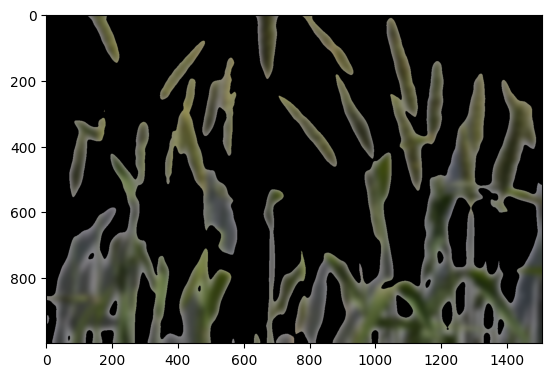

In [28]:
# OTSU
image = '/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/vaib.png'

image=cv2.imread(image)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.GaussianBlur(image,(51,51),9)
image = segment_otsu(image)

plt.imshow(image)



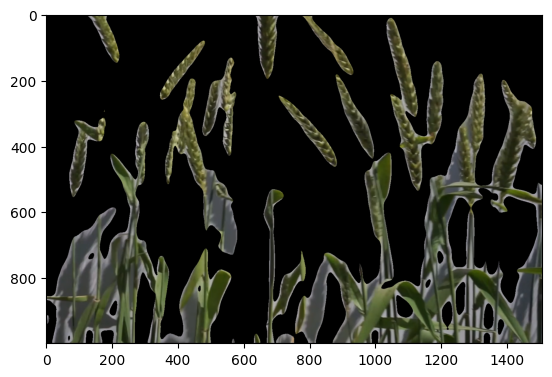

In [29]:

import cv2
image_path = '/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/vaib.png'
batu=cv2.imread(image_path)
batu=cv2.cvtColor(batu, cv2.COLOR_BGR2RGB)

batu[image[:,:,0]==0,:]=0
plt.imshow(batu)

# cv2.imwrite('otsu_wh_detection_2.jpg',batu)

OTSU + YOLO --> can miss some wheat head detection

SAM + YOLO --> sam can miss some wheat head's segmentation

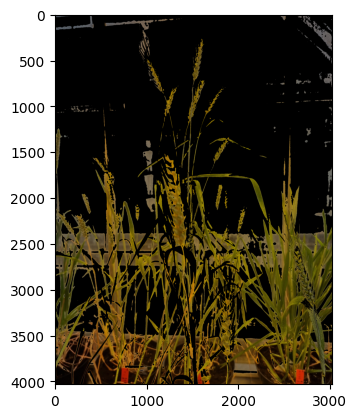

In [48]:
# OTSU
image = '/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/20240417_144256.jpg'

image=cv2.imread(image)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.GaussianBlur(image,(5,5),0)
image = segment_otsu(image)

plt.imshow(image)


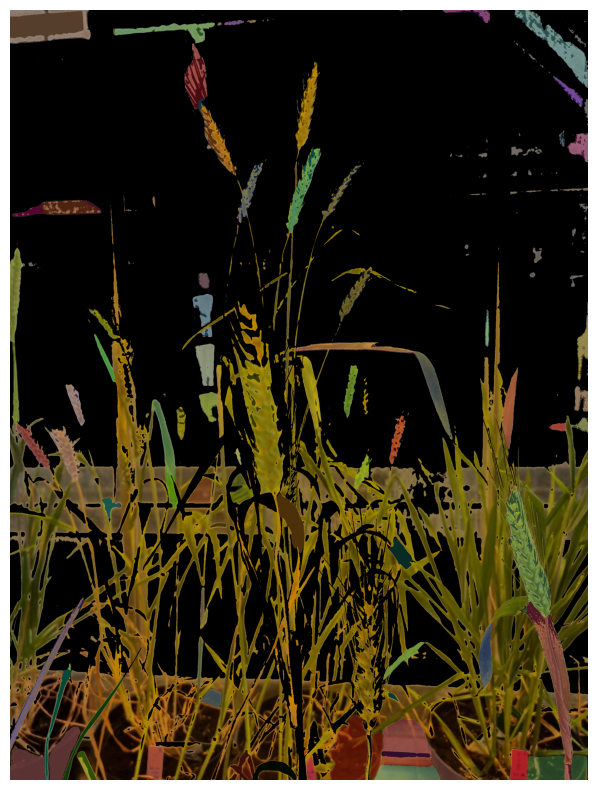

In [40]:
from utils.thresholdingW import segment_otsu

#new_image = '/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/20240417_144256.jpg'

#image=cv2.imread(new_image)
#image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


masks = mask_generator.generate(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
mask=show_anns(masks)
plt.axis('off')
plt.show() 


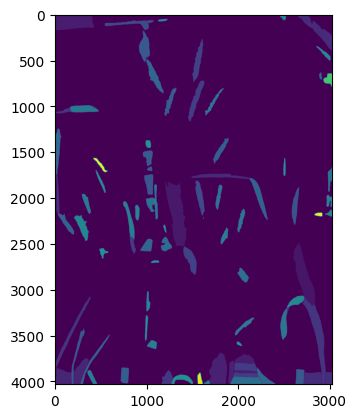

In [41]:
plt.imshow(mask)

In [109]:
[1158.74047852,  130.12913513, 1213.48596191,  374.75784302]

[1158.74047852, 130.12913513, 1213.48596191, 374.75784302]

In [110]:
cv2.imwrite('batu.jpg',batu)

True

In [111]:
np.shape(image[mask>0,:])

(363743, 3)

In [112]:
np.shape(image)

(998, 1507, 3)

## Wheathead bboxes with SAM masks

In [113]:
import pandas as pd

bboxes=pd.read_csv('/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict53/boxCoord.txt')
bboxes.head()

x1          y1           x2          y2      conf   label 
0   682.807434  215.733932   890.793091  472.819275  0.905726      0.0
1   336.513794   55.710514   503.957886  275.515961  0.894379      0.0
2   776.290588    1.000264   942.255676  197.160553  0.890721      0.0
3  1031.265015    7.614469  1135.554688  315.909271  0.874982      0.0
4   137.567780    0.924956   234.045853  142.213058  0.873953      0.0

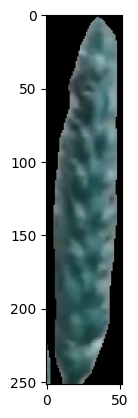

In [161]:
i=7
x1,y1,x2,y2= bboxes.iloc[i,:4].values
plt.imshow(batu[int(y1):int(y2),int(x1):int(x2)])

In [162]:
uniq_masks_bbox, counts = np.unique(mask[int(y1):int(y2),int(x1):int(x2)], return_counts=True)
print(dict(zip(uniq_masks_bbox,counts)))
print(uniq_masks_bbox[np.argmax(counts)])

{0.0: 4571, 1.0: 8533}
1.0


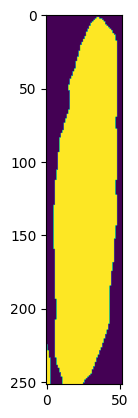

In [163]:
filter_mask_label=1
plt.imshow(mask[int(y1):int(y2),int(x1):int(x2)]==filter_mask_label)

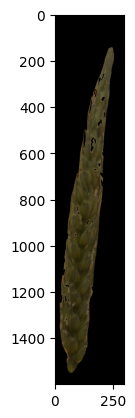

In [29]:
y1, y2, x1, x2 = 1200,2800, 2300,2600


temp=batu[int(y1):int(y2),int(x1):int(x2),:].copy()
temp_mask=mask[int(y1):int(y2),int(x1):int(x2)].copy()
#temp[temp_mask!=filter_mask_label,:]=0
plt.imshow(temp)

In [31]:
cv.imwrite('batu_wh_HR.jpg',temp)

True

In [166]:
# cv2.connectedComponents

## Applying +preprocessing on the detected wheat head after filtering out the main wheathead component

In [30]:
import cv2

img_path = '/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/batu_wh_HR.jpg'
edgeimg = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
image =  cv2.imread(img_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# image=temp.copy()
# edge_img=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

edgeimg=cv2.equalizeHist(edgeimg)
edgeimg = cv2.dilate(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=3)-cv2.erode(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[2,2]) ,iterations=2) 
edgeimg=cv2.equalizeHist(edgeimg)

edgeimg=cv2.merge([edgeimg]*3)/255
image=np.uint8(cv2.multiply(edgeimg,image/255)*255)


image = cv2.pyrUp(image)

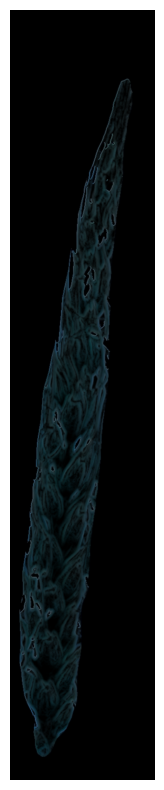

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [109]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)





In [28]:
masks2 = mask_generator_2.generate(image)

In [29]:
len(masks2)

203

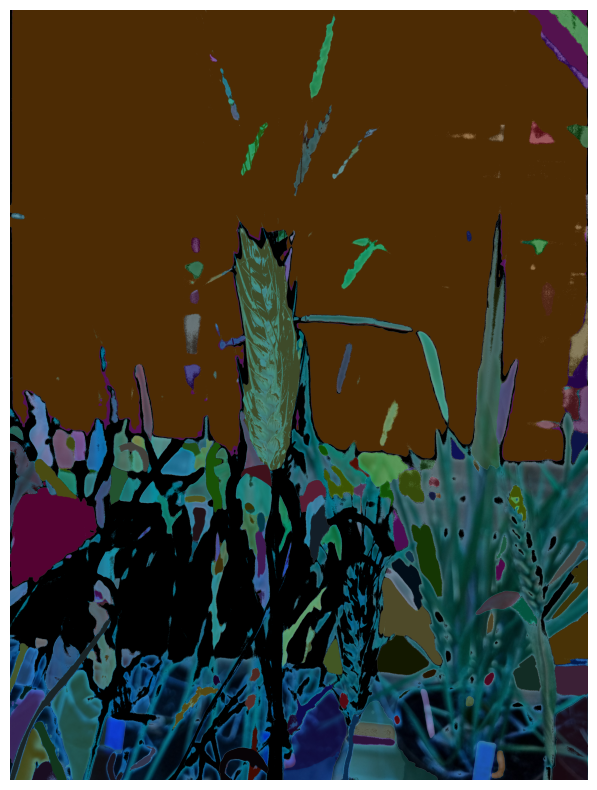

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [36]:
frame = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/batu_wh_HR.jpg")
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

grain_masks = mask_generator_2.generate(frame)

plt.figure(figsize=(10,10))
plt.imshow(frame)
#mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 

NameError: name 'mask_generator_2' is not defined

## Predicting with yolo grain model

In [1]:
from ultralytics import YOLO

model = YOLO("runs/detect/train24/weights/best.pt") 

model.predict(batu[1700:2500, 0:300], save=True,conf=0.1)

KeyboardInterrupt: 

In [43]:
from ultralytics import YOLO

model = YOLO("runs/detect/train24/weights/best.pt") 
frame = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/DATASET_GRAIN/training_dataset/1409.jpg")
# frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


model.predict(frame, save=True,conf=0.5)



0: 640x160 15 grains, 19.5ms
0: 640x160 15 grains, 19.5ms
Speed: 1.5ms preprocess, 19.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 160)
Speed: 1.5ms preprocess, 19.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 160)
Results saved to runs/detect/predict83
Results saved to runs/detect/predict83


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'grain'}
 obb: None
 orig_img: array([[[183, 183, 183],
         [181, 181, 181],
         [189, 189, 189],
         ...,
         [176, 176, 176],
         [176, 176, 176],
         [176, 176, 176]],
 
        [[184, 184, 184],
         [181, 181, 181],
         [187, 187, 187],
         ...,
         [176, 176, 176],
         [176, 176, 176],
         [176, 176, 176]],
 
        [[184, 184, 184],
         [181, 181, 181],
         [184, 184, 184],
         ...,
         [176, 176, 176],
         [176, 176, 176],
         [176, 176, 176]],
 
        ...,
 
        [[141, 145, 146],
         [141, 145, 146],
         [141, 145, 146],
         ...,
         [146, 149, 153],
         [146, 149, 153],
         [145, 148, 152]],
 
        [[141, 145, 146],
         [141, 145, 146],
         [141, 145, 146],
         ...,
         [147, 150,

## Preprocessing and segmentation using image processing

### RAG based segmentation

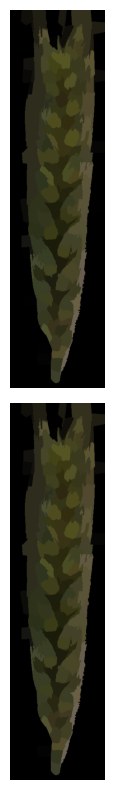

In [31]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt
import cv2
from utils.thresholdingW import segment_otsu


img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/DATASET_GRAIN/training_dataset/5118.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.GaussianBlur(img,(3,3),1)
img = segment_otsu(img)

labels1 = segmentation.slic(img, compactness=20, n_segments=250, start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 3)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()


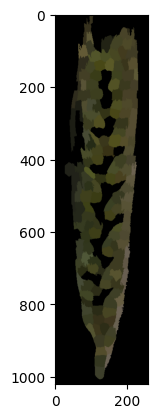

In [4]:
temp_color=out2.copy()
temp_color[temp_color[:,:,2]<20,:]=0
plt.imshow(temp_color)

In [5]:
grain_masks = mask_generator.generate(temp_color)

plt.figure(figsize=(10,10))
plt.imshow(temp_color)
mask=show_anns(grain_masks)
plt.axis('off')
plt.show() 

NameError: name 'mask_generator' is not defined

### Edge contour based segmentation

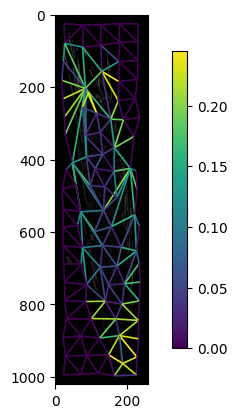

In [7]:
from skimage import graph
from skimage import data, segmentation, color, filters, io
from matplotlib import pyplot as plt
import cv2
from utils.thresholdingW import segment_otsu

img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/DATASET_GRAIN/training_dataset/1409.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.GaussianBlur(img,(3,3),1)
img = segment_otsu(img)
gimg = color.rgb2gray(img)

labels = segmentation.slic(img, compactness=25, n_segments=100, start_label=1)
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(
    labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis', edge_width=1.2
)

plt.colorbar(lc, fraction=0.03)
io.show()

### Intensity histogram and intensity filtering 

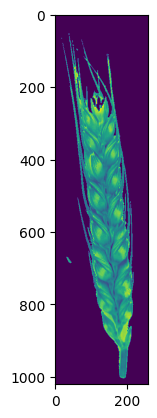

In [12]:
import numpy as np
# temp=gimg.copy()
temp=img[:,:,1].copy()
# temp[(temp<0.2) ]=0
# temp[ (temp>0.52)]=0
plt.imshow(temp)

(array([[1021.,    0.,    0., ...,    0.,    0.,    0.],
        [1021.,    0.,    0., ...,    0.,    0.,    0.],
        [1021.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1021.,    0.,    0., ...,    0.,    0.,    0.],
        [1021.,    0.,    0., ...,    0.,    0.,    0.],
        [1021.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0. ,  12.1,  24.2,  36.3,  48.4,  60.5,  72.6,  84.7,  96.8,
        108.9, 121. ]),
 <a list of 256 BarContainer objects>)

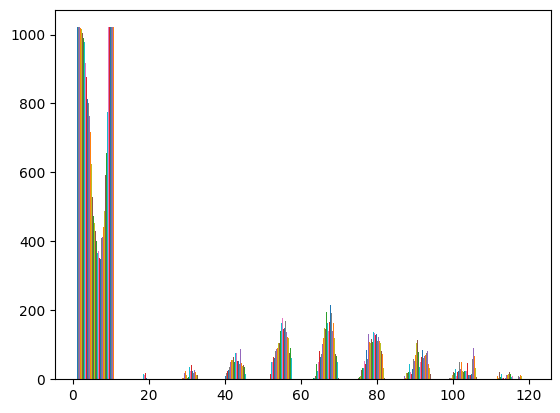

In [13]:
plt.hist(temp)

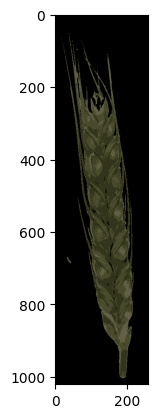

In [27]:
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(res2)

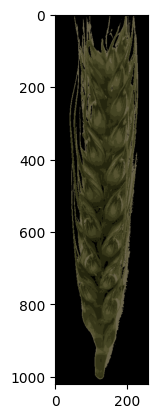

In [36]:
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(res2)

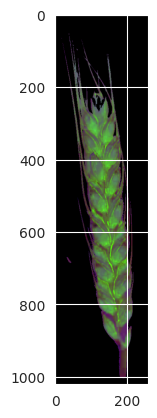

In [123]:
rgb_img = img.copy()
hsv_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2HSV)
plt.imshow(hsv_img)

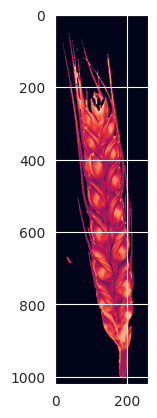

In [134]:
plt.imshow(hsv_img[:,:,2])

### Random walker with markers based segmentation

In [147]:
import cv2
from utils.thresholdingW import segment_otsu
# img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict28/crops/wheat/vaib2.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/DATASET_GRAIN/training_dataset/1409.jpg")
# img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/batu_wh_HR.jpg")
# img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = segment_otsu(img)

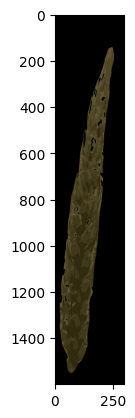

In [148]:
Z = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(Z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
plt.imshow(res2)

In [149]:
np.shape(res2)

(1600, 300, 3)

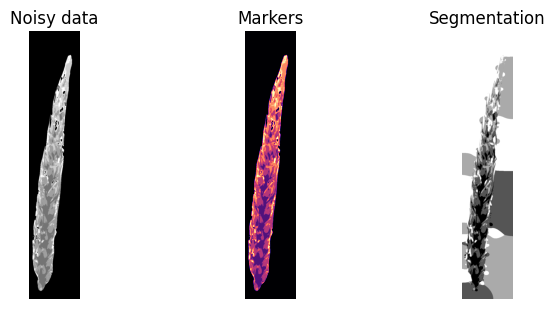

In [150]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

rng = np.random.default_rng()

# # Generate noisy synthetic data
# data = skimage.img_as_float(binary_blobs(length=128, rng=1))
# sigma = 0.35
# data += rng.normal(loc=0, scale=sigma, size=data.shape)
# data = rescale_intensity(data, in_range=(-sigma, 1 + sigma), out_range=(-1, 1))

data=cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY) 
# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
uniq_intensity=np.array(np.unique(data))
for i in range(len(uniq_intensity)):
    markers[data == uniq_intensity[i]] = i

# Run random walker algorithm
labels = random_walker(data, markers, beta=1, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2), sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

In [151]:
len(np.unique(img))

145

In [152]:
print(np.unique(markers))
print(np.unique(labels))

[0 1 2 3 4]
[1 2 3 4]


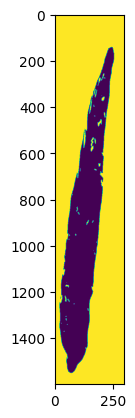

In [153]:
plt.imshow(labels!=markers)

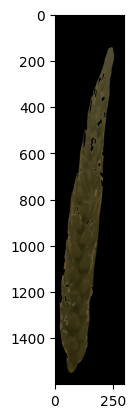

In [154]:
plt.imshow(cv.pyrMeanShiftFiltering(img, sp=100,sr=10) )

In [155]:
t2=img.copy()
thresh = cv2.cvtColor(t2, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 101, 0)
count, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
for i in range(1,count):
    t2 = cv2.circle(t2, (int(centroids[i,0]), int(centroids[i,1])), 5, (0, 255, 0, 0), 5)


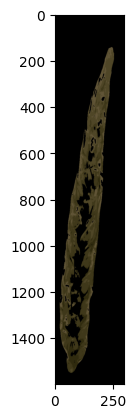

In [156]:
img1=res2.copy()
img1[thresh==255,:]=0
# img1=cv.GaussianBlur(img1,(3,3),1)
plt.imshow(img1)

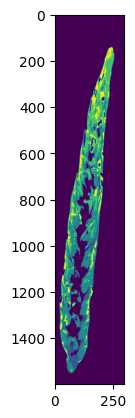

In [157]:
plt.imshow(img1[:,:,2])

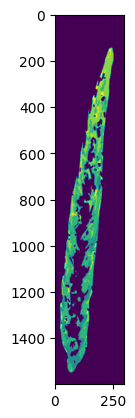

In [158]:
from utils.thresholdingW import segment_otsu
edgeimg=img1[:,:,1].copy()
edgeimg=edgeimg/np.max(edgeimg)
# edgeimg=cv2.equalizeHist(edgeimg)
# edgeimg = cv2.dilate(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=3)-cv2.erode(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[2,2]) ,iterations=2) 
edgeimg = cv2.erode(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=2) 
# edgeimg = cv2.dilate(edgeimg,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[2,2]) ,iterations=3)
# edgeimg=cv2.equalizeHist(edgeimg)

# edgeimg=cv2.merge([edgeimg]*3)/255
# image=np.uint8(cv2.multiply(edgeimg,image/255)*255)
plt.imshow(edgeimg)

Number of Circular Blobs: 34


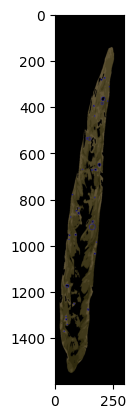

In [159]:
imagec=img1.copy()
# Set our filtering parameters 
# Initialize parameter setting using cv2.SimpleBlobDetector 
params = cv2.SimpleBlobDetector_Params() 
  
# Set Area filtering parameters 
params.filterByArea = True
params.minArea = 10
  
# Set Circularity filtering parameters 
params.filterByCircularity = True 
params.minCircularity = 0.1
  
# Set Convexity filtering parameters 
params.filterByConvexity = True
params.minConvexity = 0.8
      
# Set inertia filtering parameters 
params.filterByInertia = True
params.minInertiaRatio = 0.1
  
# Create a detector with the parameters 
detector = cv2.SimpleBlobDetector_create(params) 
      
# Detect blobs 
keypoints = detector.detect(imagec) 
  
# Draw blobs on our image as red circles 
blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(imagec, keypoints, blank, (0, 0, 255), 
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
number_of_blobs = len(keypoints) 
text = "Number of Circular Blobs: " + str(len(keypoints)) 
# cv2.putText(blobs, text, (20, 550), 
#             cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2) 
print(text)

plt.imshow(blobs)

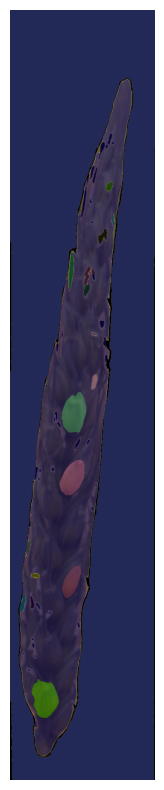

In [160]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.88,
    crop_n_layers=2,
    crop_n_points_downscale_factor=5,
    min_mask_region_area=300,  # Requires open-cv to run post-processing
)


masks2 = mask_generator_2.generate(img)

plt.figure(figsize=(10,10))
plt.imshow(img)
show_anns(masks2)
plt.axis('off')
plt.show() 


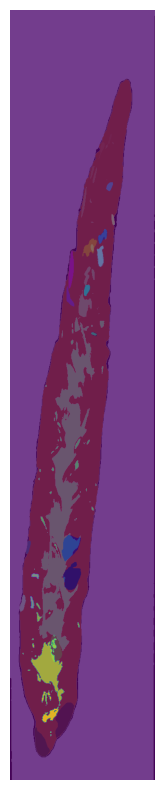

In [161]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.88,
    crop_n_layers=2,
    crop_n_points_downscale_factor=5,
    min_mask_region_area=500,  # Requires open-cv to run post-processing
)

masks2 = mask_generator_2.generate(res2)

plt.figure(figsize=(10,10))
plt.imshow(labels)
show_anns(masks2)
plt.axis('off')
plt.show() 


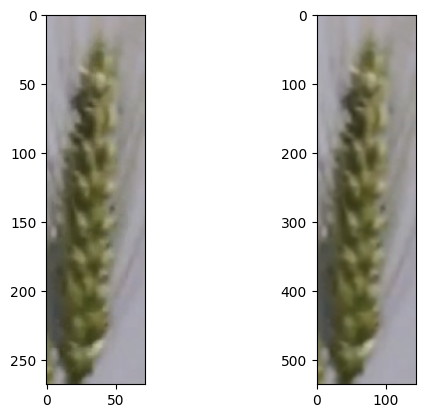

In [5]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/runs/detect/predict28/crops/wheat/vaib2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

imageUP = cv2.pyrUp(image)

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(imageUP)

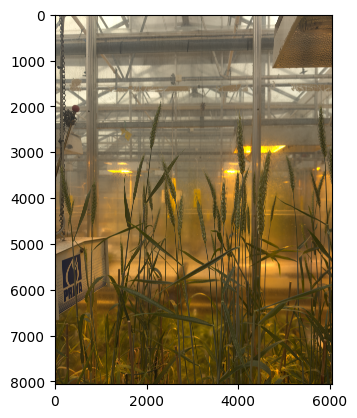

In [3]:
import rawpy
import imageio
import matplotlib.pyplot as plt

with rawpy.imread('IMG_6230.DNG') as raw:
    image = raw.postprocess()

plt.imshow(image)

In [191]:
grain_masks[0]

{'segmentation': array([[False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False]]),
 'area': 116199,
 'bbox': [0, 0, 299, 799],
 'predicted_iou': 1.0148324966430664,
 'point_coords': [[14.0625, 737.5]],
 'stability_score': 0.9634838700294495,
 'crop_box': [0, 0, 300, 800]}

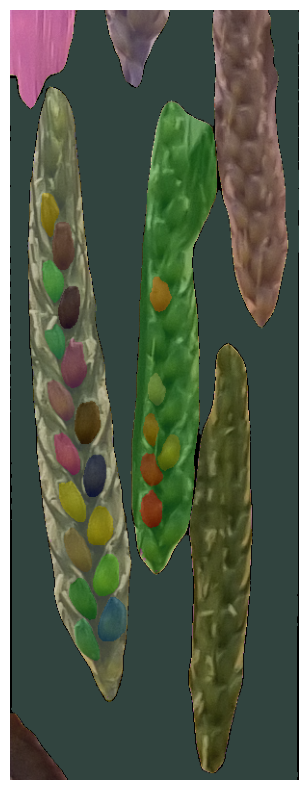

In [193]:
plt.figure(figsize=(10,10))
plt.imshow(batu[1700:2500, 0:300])
mask=show_anns(grain_masks)
plt.axis('off')
plt.show()


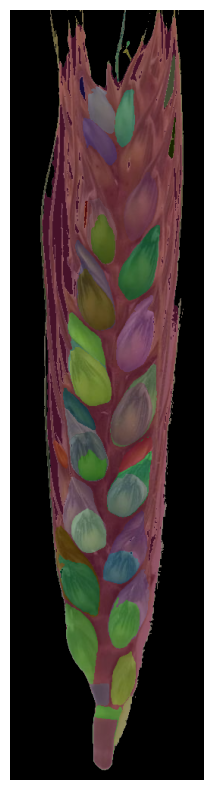

In [5]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt
import cv2
from utils.thresholdingW import segment_otsu


img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/DATASET_GRAIN/training_dataset/5118.jpg")
# img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/wh_sam_density.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.GaussianBlur(img,(3,3),1)
img = segment_otsu(img)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=5,
    min_mask_region_area=400,  # Requires open-cv to run post-processing
)


masks2 = mask_generator_2.generate(img)

plt.figure(figsize=(10,10))
plt.imshow(img)
masks2_labels=show_anns(masks2)
plt.axis('off')
plt.show() 

In [12]:
masks2_labels == 10

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

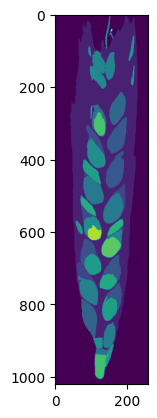

In [201]:
plt.imshow(masks2_labels)

In [ ]:
# connected components for combining intra-grain masks ( check for inter-grain connectedness for masks)
# identify grain mask vs no grain mask area
# fill up the remaining area using average grain mask shape 
# Grid-like area mapping formation

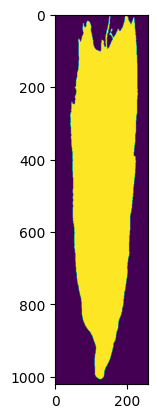

In [202]:
plt.imshow(masks2_labels>0)

In [213]:
gray_img.dtype

dtype('float64')

In [13]:


import cv2 
import numpy as np 
  
  
# preprocess the image 
gray_img = masks2_labels.copy() 
gray_img=gray_img.astype('uint8')
gray_img[gray_img==10]=0
# # Applying 7x7 Gaussian Blur 
# blurred = cv2.GaussianBlur(gray_img, (7, 7), 0) 
  
# # Applying threshold 
# threshold = cv2.threshold(gray_img, 0, 255, 
#     cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]  
  
# Apply the Component analysis function 
analysis = cv2.connectedComponentsWithStats(gray_img, 
                                            4, 
                                            cv2.CV_32S) 
(totalLabels, label_ids, values, centroid) = analysis 
  
# Initialize a new image to store  
# all the output components 
output = np.zeros(gray_img.shape, dtype="uint8") 
  
# Loop through each component 
for i in range(1, totalLabels): 
    
      # Area of the component 
    area = values[i, cv2.CC_STAT_AREA]  
      
    if (area > 500) and (area < 10000000): 
        print(i)
        # componentMask = (label_ids == i).astype("uint8") * 255
        # output = cv2.bitwise_or(output, componentMask)
        output[label_ids == i] =i 
  
 

5
7
8
10
11
12
13
14
15
16
18
19
20
21


In [25]:
np.shape(label_ids)

(1021, 256)

In [255]:
# unique, counts = np.unique(gray_img, return_counts=True)
# print(np.asarray((unique, counts)).T)

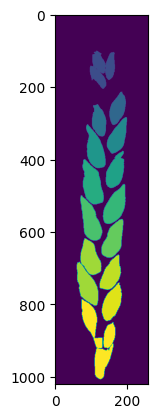

In [256]:
plt.imshow(output)

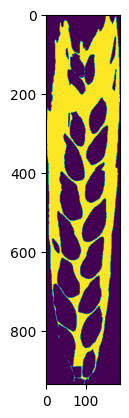

In [295]:
temp=masks2_labels.copy()
temp[temp!=10]=0
# temp[output==0]=0
temp=temp[np.sum(temp,1)>0]
temp=temp[:,np.sum(temp,0)>0]
plt.imshow(temp)

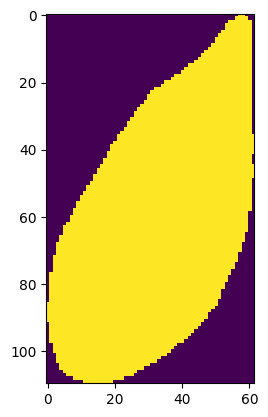

In [124]:
temp_mask=output.copy()
# temp_mask = cv2.erode(temp_mask,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=5) 
temp_mask[temp_mask!=14]=0
temp_mask=temp_mask[np.sum(temp_mask,1)>0]
temp_mask=temp_mask[:,np.sum(temp_mask,0)>0]
plt.imshow(temp_mask)

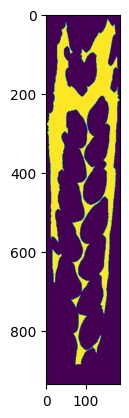

In [297]:
# temp = 
plt.imshow(cv2.erode(temp,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=5) )

In [292]:
np.shape(temp)

(1021, 256)

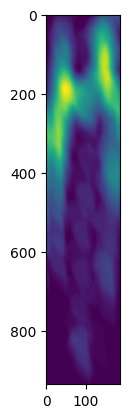

In [298]:
tempCmask=cv2.filter2D(src=cv2.erode(temp,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=8) , ddepth=-1, kernel=temp_mask)
# tempCmask[tempCmask!=np.max(tempCmask)]=0
plt.imshow( tempCmask)

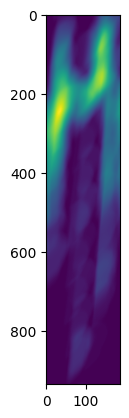

In [299]:
tempCmask=cv2.filter2D(src=cv2.erode(temp,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=8) , ddepth=-1, kernel=cv2.flip(temp_mask,1))
# tempCmask[tempCmask!=np.max(tempCmask)]=0
plt.imshow( tempCmask)

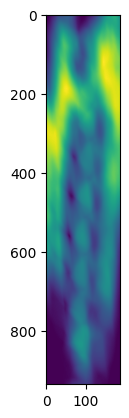

In [300]:
tempCmask=cv2.filter2D(src=temp, ddepth=-1, kernel=temp_mask)
# tempCmask[tempCmask!=np.max(tempCmask)]=0
plt.imshow( tempCmask)

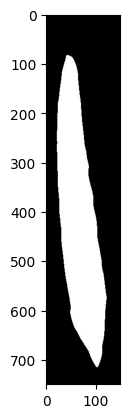

In [346]:
img = cv2.imread("/home/slu/Desktop/ajit_fasterrcnn/fasterrcnn-pytorch-training-pipeline-main/wh_sam_density.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.erode(img,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=3)
plt.imshow(img)

In [347]:
thresh=img.copy()
thresh=(thresh>0)*255
thresh=thresh.astype('uint8')
contours,hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv2.moments(cnt)
print( M )

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/contours.cpp:192: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [349]:
thresh=img.copy()
np.unique(thresh)

array([  0,   1,   2,   3,   4,   5,   6, 248, 249, 250, 251, 252, 253,
       254, 255], dtype=uint8)

In [350]:
plt.imshow(img>0)

Error in callback <function _draw_all_if_interactive at 0x7e8af4e62700> (for post_execute), with arguments args (),kwargs {}:


ValueError: arrays must be of dtype byte, short, float32 or float64

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 640x480 with 1 Axes>

In [342]:
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.intp(box)
cv2.drawContours(thresh,[box],0,(0,0,255),2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [343]:
rect

((87.0, 686.0), (0.0, 0.0), 0.0)

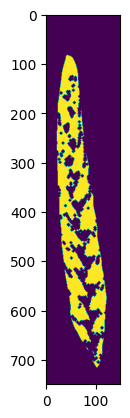

In [344]:
plt.imshow(thresh)

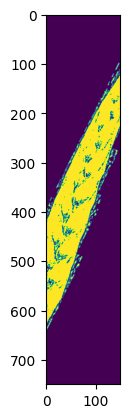

In [334]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
plt.imshow(rotate_image(thresh,360-26.565))

In [28]:
np.shape(masks2_labels>0)

(1021, 256)

In [86]:
print(np.shape(output), np.shape(imgg[output>0]))

(1021, 256) (1021, 256)


In [95]:
np.shape(imgg)
imgg.reshape()

(60908,)

(1021, 256)

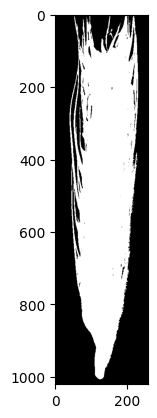

In [115]:
imgg = img.copy()
imgg = cv2.cvtColor(imgg, cv2.COLOR_RGB2GRAY)
#imgg =  cv2.resize(imgg[output>0], (1021, 256))
plt.imshow(imgg>0, cmap='gray')
np.shape(imgg)

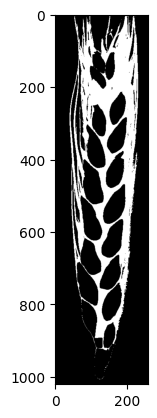

In [116]:

imgg[output>0]=0

plt.imshow(imgg>0, cmap='gray')

In [123]:
temp_mask=output.copy()
# temp_mask = cv2.erode(temp_mask,kernel=cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE,ksize=[3,3]) ,iterations=5) 
temp_mask[150]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)